# LDA Tutorial using gensim

The following notebook demonstrates the topic modeling of the minutes of the Federal Open Market Committee (FOMC) meetings.

Original source: [Modeling Topic Trends in FOMC Meetings](https://highdemandskills.com/topic-trends-fomc/)

## Install spacy NPL pipeline

In [ ]:
#Only needs to be done once. Takes sometime.
#Restart runtime after download is complete
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 827.9 MB 1.1 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=ce646d32f813b4455f1b9b97e75fa38d68c9c5a3d5b54b65dd3b2d661431d00b
  Stored in directory: /tmp/pip-ephem-wheel-cache-q833pn7y/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Import libraries

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load default trained pipeline package (https://spacy.io/models/en)
# Used for parsing 
# Parsing = resolve (a sentence) into its component parts and describe their syntactic roles.
nlp = spacy.load('en_core_web_lg')
# In case max_length is set to lower than this (ensure sufficient memory)
nlp.max_length = 1500000 


## Get documents by passing thr URLS

In [ ]:
# Define URLs for the specific FOMC minutes
URLPath = r'https://www.federalreserve.gov/monetarypolicy/fomcminutes'
URLExt = r'.htm'

# List for FOMC minutes from 2007 onward
MinutesList = ['20071031', '20071211',                                                                     # 2007 FOMC minutes (part-year on new URL format)
           '20080130', '20080318', '20080430', '20080625', '20080805', '20080916', '20081029', '20081216', # 2008 FOMC minutes     
           '20090128', '20090318', '20090429', '20090624', '20090812', '20090923', '20091104', '20091216', # 2009 FOMC minutes 
           '20100127', '20100316', '20100428', '20100623', '20100810', '20100921', '20101103', '20101214', # 2010 FOMC minutes 
           '20110126', '20110315', '20110427', '20110622', '20110809', '20110921', '20111102', '20111213', # 2011 FOMC minutes 
           '20120125', '20120313', '20120425', '20120620', '20120801', '20120913', '20121024', '20121212', # 2012 FOMC minutes 
           '20130130', '20133020', '20130501', '20130619', '20130731', '20130918', '20131030', '20131218', # 2013 FOMC minutes 
           '20140129', '20140319', '20140430', '20140618', '20140730', '20140917', '20141029', '20141217', # 2014 FOMC minutes                   
           '20150128', '20150318', '20150429', '20150617', '20150729', '20150917', '20151028', '20151216', # 2015 FOMC minutes    
           '20160127', '20160316', '20160427', '20160615', '20160727', '20160921', '20161102', '20161214', # 2016 FOMC minutes
           '20172001', '20170315', '20170503', '20170614', '20170726', '20170920', '20171101', '20171213', # 2017 FOMC minutes
           '20180131', '20180321', '20180502', '20180613', '20180801', '20180926', '20181108', '20181219', # 2018 FOMC minutes
           '20190130', '20190320', '20190501', '20190619', '20190731', '20190918', '20191030', '20191211', # 2019 FOMC minutes
           '20200129', '20200315', '20200429', '20200610', '20200729']                                     # 2020 FOMC minutes


## Setting up the corpus

In [ ]:
# Define function to prepare corpus
def PrepareCorpus(urlpath, urlext, minslist, minparalength):
    """
    Function to prepare corpus.

    Parameters
    -------------
    urlpath:  string
      URL path
    urlext:   string
      URL extension
    minslist: list
      List of minutes to be used
    minparalength: int
      Minimum length for text to be considered a paragraph

    Returns
    ------------
    fomcmins:         list of lists
      List of lists to form corpus. There are as many list as paragraphs. 
      Inner list contains lemmatized words from each paragraph.
    fomcwordcloud:    list
      Single list version of the corpus.
    fomctopix:        list of tuples
      Contains minutes ID (date) and weight of each paragraph.

    """
    fomcmins = []
    fomcwordcloud = []
    fomctopix = []
    
    for minutes in minslist:
        # Get the URL response
        response = requests.get(urlpath + minutes + urlext) 
        # Parse the response
        soup = BeautifulSoup(response.content, 'lxml') 
        
        # Extract minutes content and convert to string
        # Contained within the 'div' tag
        minsTxt = str(soup.find("div", {"id": "content"})) 
                    
        # Clean text - stage 1
        # Remove white space at the beginning and end
        minsTxt = minsTxt.strip()  
        # Replace the \r with null
        minsTxt = minsTxt.replace('\r', '') 
        # Replace " " with space.
        minsTxt = minsTxt.replace(' ', ' ') 
        # Replace " " with space. 
        minsTxt = minsTxt.replace(' ', ' ')
        # Remove extra spaces
        while '  ' in minsTxt:
            minsTxt = minsTxt.replace('  ', ' ') 

        # Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)    
        minsTxt = re.sub(r'(<[^>]*>)|'    # Remove content within HTML tags
                         '([_]+)|'        # Remove series of underscores
                         '(http[^\s]+)|'  # Remove website addresses
                         '((a|p)\.m\.)',  # Remove "a.m" and "p.m."
                         '', minsTxt)     # Replace with null

        # Find length of minutes document for calculating paragraph weights
        # List of paras in minsTxt, where minsTxt is split based on new line characters
        minsTxtParas = minsTxt.split('\n') 
        # Set up variable for cumulative word-count in all paras for a given minutes transcript
        cum_paras = 0 
        for para in minsTxtParas:
          # Only including paragraphs larger than 'minparalength'
          if len(para)>minparalength: 
              cum_paras += len(para)
        
        # Extract paragraphs
        for para in minsTxtParas:
          # Only extract paragraphs larger than 'minparalength'
          if len(para)>minparalength: 
              
              # Temporary list to store minutes date & para weight tuple
              topixTmp = [] 
              # First element of tuple (minutes date)
              topixTmp.append(minutes) 
              # Second element of tuple (para weight), NB. Calculating weights based on pre-SpaCy-parsed text
              topixTmp.append(len(para)/cum_paras) 
                          
              # Parse cleaned para with SpaCy
              minsPara = nlp(para)
              
              minsTmp = [] # Temporary list to store individual tokens
              
              # Further cleaning and selection of text characteristics
              for token in minsPara:
                  # Retain words that are not a stop word nor punctuation, and only if a Noun, Adjective or Verb
                  if token.is_stop == False and token.is_punct == False and (token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ =="VERB"): 
                      # Convert to lower case and retain the lemmatized version of the word (this is a string object)
                      minsTmp.append(token.lemma_.lower()) 
                      # Add word to WordCloud list
                      fomcwordcloud.append(token.lemma_.lower()) 
              fomcmins.append(minsTmp) # Add para to corpus 'list of lists'
              fomctopix.append(topixTmp) # Add minutes date & para weight tuple to list for storing
            
    return fomcmins, fomcwordcloud, fomctopix


In [ ]:
# A list of lists to form the corpus
# There are as many list as paragraphs
# Inner list contains lemmatized words contained in a paragraph
FOMCMinutes = [] 
# Single list version of the corpus for WordCloud
FOMCWordCloud = [] 
# List of tuples. Contains minutes ID (date) and weight of each paragraph
FOMCTopix = [] 


# Prepare corpus
FOMCMinutes, FOMCWordCloud, FOMCTopix = PrepareCorpus(urlpath=URLPath, urlext=URLExt, minslist=MinutesList, minparalength=200)


In [ ]:
print(FOMCWordCloud[0:10],'\n', len(FOMCWordCloud))

['meeting', 'hold', 'office', 'continue', 'sheet', 'economist', 'unanimous', 'vote', 'select', 'serve'] 
 376655


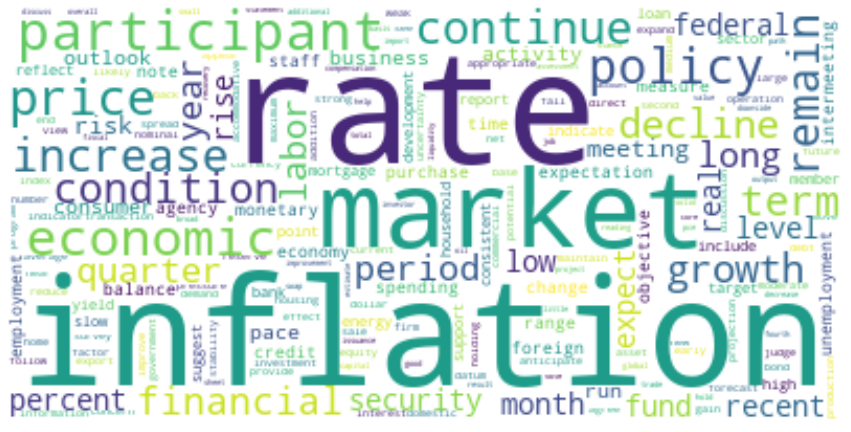

In [ ]:
# Generate and plot WordCloud for full corpus
# Include bigrams by setting collocations to True
# 'join' method used to convert the documents list to text format
wordcloud = WordCloud(background_color="white", collocations=False).generate(','.join(FOMCWordCloud)) 

plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

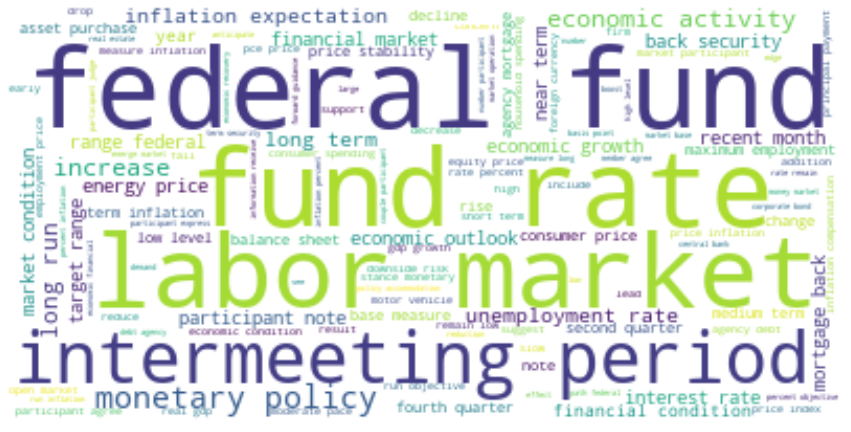

In [ ]:
# Generate and plot WordCloud for full corpus
# Include bigrams by setting collocations to True
# 'join' method used to convert the documents list to text format
wordcloud = WordCloud(background_color="white", collocations=True).generate(','.join(FOMCWordCloud)) 

plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Numeric representation of the corpus using TF_IDF 

In [ ]:
# Form dictionary by mapping word IDs to words
# https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.html
ID2word = corpora.Dictionary(FOMCMinutes)

# Set up Bag of Words and TFIDF
# doc2bow converts a collection of words to its bag-of-words representation: a list of (word_id, word_frequency) 2-tuples.
corpus = [ID2word.doc2bow(doc) for doc in FOMCMinutes] 
# TFIDF = term frequency–inverse document frequency https://en.wikipedia.org/wiki/Tf%E2%80%93idf
# Fit TF-IDF model
TFIDF = models.TfidfModel(corpus) 
# Apply TF-IDF model
trans_TFIDF = TFIDF[corpus]


In [ ]:
dummy_index = 1
print(trans_TFIDF[dummy_index])
for word in trans_TFIDF[dummy_index]:
  print(ID2word[word[0]])

[(4, 0.8962209734406998), (5, 0.4436078975457993)]
economist
sheet


# Set up the LDA model

In [ ]:
# Set random seed
SEED = 130 
# Set number of topics
NUM_topics = 10
# Set alpha 
ALPHA = 0.11 #1/NUM_topics
# Set eta 
ETA = 0.12#1/NUM_topics
# Number of passes
passes = 2

In [ ]:
# Train LDA model using the corpus
lda_model = gensim.models.LdaMulticore(corpus=trans_TFIDF, 
                                       num_topics=NUM_topics, 
                                       id2word=ID2word, 
                                       random_state=SEED, 
                                       alpha=ALPHA, 
                                       eta=ETA, 
                                       passes=passes)

# Print topics generated from the training corpus
pprint(lda_model.print_topics(num_words=10))


[(0,
  '0.014*"required" + 0.008*"mortgage" + 0.008*"vote" + 0.007*"credit" + '
  '0.007*"plummet" + 0.006*"farm" + 0.006*"home" + 0.006*"extraction" + '
  '0.005*"scenario" + 0.005*"approve"'),
 (1,
  '0.011*"participant" + 0.009*"risk" + 0.007*"economic" + 0.007*"policy" + '
  '0.007*"meeting" + 0.006*"staff" + 0.006*"outlook" + 0.006*"financial" + '
  '0.006*"dollar" + 0.005*"projection"'),
 (2,
  '0.016*"agency" + 0.016*"vote" + 0.015*"transaction" + 0.012*"security" + '
  '0.012*"operation" + 0.012*"direct" + 0.009*"action" + 0.009*"foreign" + '
  '0.008*"authorize" + 0.008*"holding"'),
 (3,
  '0.013*"inflation" + 0.011*"range" + 0.011*"percent" + 0.010*"objective" + '
  '0.009*"target" + 0.009*"federal" + 0.009*"member" + 0.008*"maximum" + '
  '0.008*"employment" + 0.008*"economic"'),
 (4,
  '0.009*"credit" + 0.008*"loan" + 0.008*"outbreak" + 0.007*"market" + '
  '0.007*"spread" + 0.007*"issuance" + 0.007*"bond" + 0.007*"security" + '
  '0.006*"corporate" + 0.006*"yield"'),
 (5,


# Calculate the coherence score

Coherence explained [here](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)

In [ ]:
# Set up coherence model
# Calculate topic coherence for topic models. Implementation of the four stage topic coherence pipeline:
# segmentation, probability estimation, indirect confirmation measure, aggregation
# Documentation https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/coherencemodel.py
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=FOMCMinutes, dictionary=ID2word, coherence='c_v')



# Calculate and print coherence
coherence_lda = coherence_model_lda.get_coherence()
print('-'*50)
print('\nCoherence Score:', coherence_lda)
print('-'*50)


--------------------------------------------------

Coherence Score: 0.5607568861088456
--------------------------------------------------


# Generate weighted topic proportions for copus

In [ ]:
FOMCTopix_new = FOMCTopix.copy()

# Set document counter
para_no = 0 
for para in FOMCTopix:
    TFIDF_para = TFIDF[corpus[para_no]] # Apply TFIDF model to individual paragraphs in minutes documents
    # Generate and store weighted topic proportions for each para
    # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
    for topic_weight in lda_model.get_document_topics(TFIDF_para): 
        # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
        FOMCTopix_new[para_no].append(FOMCTopix_new[para_no][1]*topic_weight[1]) 
    para_no += 1


# Generate aggegate topix mix over each minutes transcript

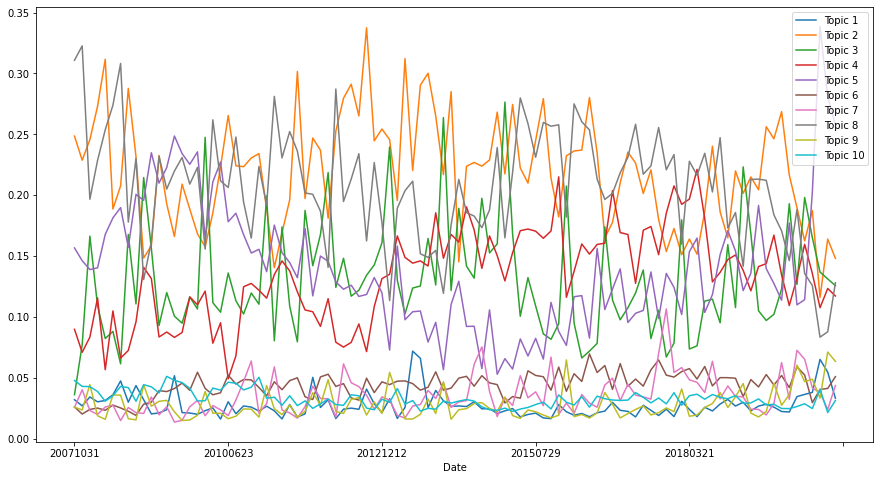

In [ ]:
# List of topics
Topic_list = []
for i in range(NUM_topics):
  Topic_list.append('Topic '+str(i+1))
Columns = ['Date', 'Weight'] + Topic_list

# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(FOMCTopix_new, columns=Columns)

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=Topic_list, index='Date', aggfunc=np.sum)

# Plot results - select which topics to print
TopixAggDF.plot(y=Topic_list, kind='line', use_index=True,figsize=(15,8))


# Print topic word cloud

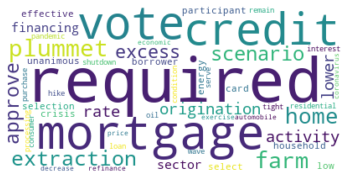

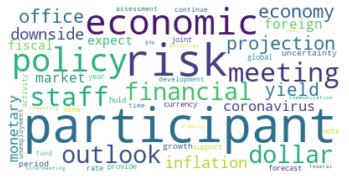

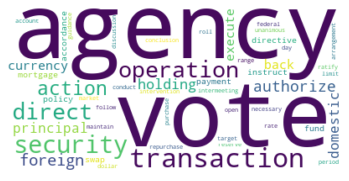

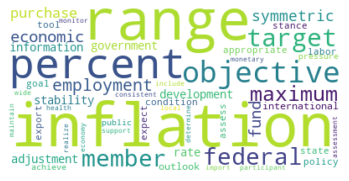

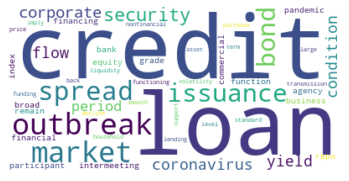

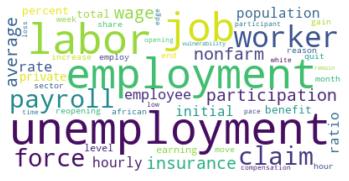

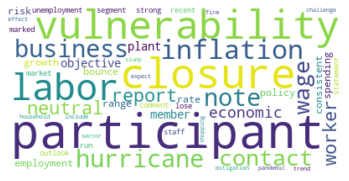

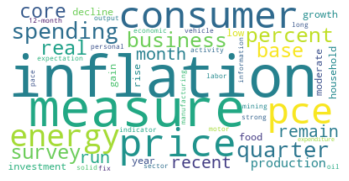

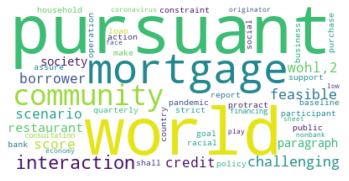

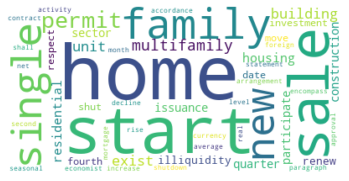

In [ ]:

topic = 0 # Initialize counter
while topic < NUM_topics:
    # Get topics and frequencies and store in a dictionary structure
    # 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs 
    # This is needed as input for the 'generate_from_frequencies' word cloud function
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) 
    topic += 1
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    print('\n')

# Test coherence by varying key parameters


In [ ]:
def compute_coherence( alpha, eta, num_topics):

    model = gensim.models.LdaMulticore(corpus=trans_TFIDF, 
                                      num_topics=num_topics, 
                                      id2word=ID2word, 
                                      random_state=SEED, 
                                      alpha=alpha, 
                                      eta=eta, 
                                      passes=passes)
      
    coherencemodel = gensim.models.CoherenceModel(model=model, texts=FOMCMinutes, dictionary=ID2word, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()

    return coherence_value
  


## Coherence values for varying number of topics

In [ ]:
def compute_coherence_values_TOPICS(corpus, dictionary, alpha, seed, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           alpha=alpha, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           eta=eta, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values




In [ ]:
limit=105
start=5
step=10

model_list, coherence_values = compute_coherence_values_TOPICS(corpus=trans_TFIDF, 
                                                               dictionary=ID2word, 
                                                               alpha=ALPHA, 
                                                               seed=SEED, 
                                                               eta=ETA, 
                                                               texts=FOMCMinutes, 
                                                               start=start, 
                                                               limit=limit, 
                                                               step=step)


100%|██████████| 10/10 [03:29<00:00, 20.99s/it]


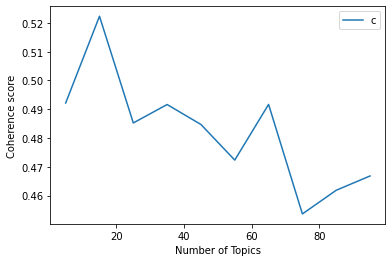

In [ ]:
# Plot graph of coherence values by varying number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying eta

In [ ]:

def compute_coherence_values_ETA(corpus, dictionary, num_topics, seed, alpha, texts, start, limit, num_step):
    coherence_values = []
    model_list = []
    for eta in tqdm(np.linspace(start, limit, num_step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           alpha=alpha, 
                                           eta=eta, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [ ]:
limit=1.5/NUM_topics
start=0.5/NUM_topics
num_step=10

model_list, coherence_values = compute_coherence_values_ETA(corpus=trans_TFIDF, 
                                                            dictionary=ID2word, 
                                                            num_topics=NUM_topics, 
                                                            seed=SEED, 
                                                            alpha=ALPHA, 
                                                            texts=FOMCMinutes, 
                                                            start=start, 
                                                            limit=limit, 
                                                            num_step=num_step)


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


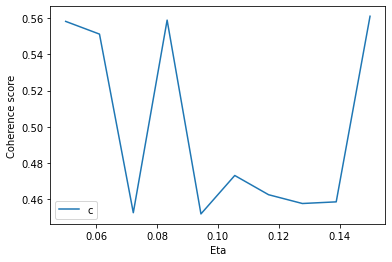

In [ ]:
# Plot graph of coherence values by varying eta
#x = range(start, limit, step)
x = np.linspace(start, limit, num_step)
plt.plot(x, coherence_values)
plt.xlabel("Eta")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying alpha

In [ ]:

def compute_coherence_values_ALPHA(corpus, dictionary, num_topics, seed, eta, texts, start, limit, num_step):
    coherence_values = []
    model_list = []
    for alpha in tqdm(np.linspace(start, limit, num_step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           num_topics=num_topics, 
                                           random_state=seed, 
                                           eta=eta, 
                                           alpha=alpha, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [ ]:
limit=1.5/NUM_topics
start=0.5/NUM_topics
num_step = 10

model_list, coherence_values = compute_coherence_values_ALPHA(dictionary=ID2word, 
                                                              corpus=trans_TFIDF, 
                                                              num_topics=NUM_topics, 
                                                              seed=SEED, 
                                                              eta=ETA, 
                                                              texts=FOMCMinutes, 
                                                              start=start, 
                                                              limit=limit, 
                                                              num_step=num_step)


100%|██████████| 10/10 [02:38<00:00, 15.88s/it]


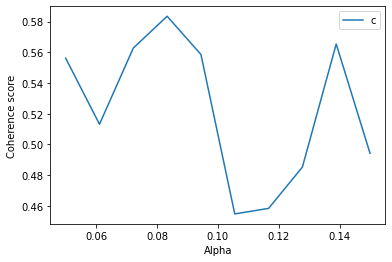

In [ ]:

# Plot graph of coherence values by varying alpha
x = np.linspace(start, limit, num_step)
plt.plot(x , coherence_values)
plt.xlabel("Alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()

## Coherence values for varying seed

In [ ]:

def compute_coherence_values_SEED(corpus, dictionary, alpha, num_topics, eta, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for seed in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=dictionary, 
                                           alpha=alpha, 
                                           num_topics=num_topics, 
                                           eta=eta, 
                                           random_state=seed, 
                                           passes=passes)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [ ]:
limit=10
start=1
step=1

model_list, coherence_values = compute_coherence_values_SEED(corpus=trans_TFIDF, 
                                                             dictionary=ID2word, 
                                                             alpha=ALPHA, 
                                                             num_topics=NUM_topics, 
                                                             eta=ETA, 
                                                             texts=FOMCMinutes, 
                                                             start=start, 
                                                             limit=limit, 
                                                             step=step)



100%|██████████| 9/9 [02:17<00:00, 15.27s/it]


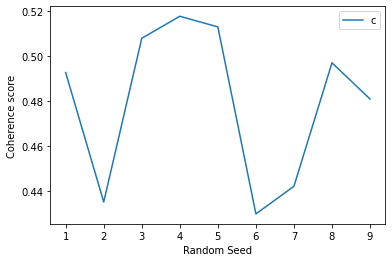

In [ ]:
# Plot graph of coherence values by varying seed
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Random Seed")
plt.ylabel("Coherence score")
plt.legend(("coherence"), loc='best')
plt.show()